In [5]:
import numpy as np
from qutip import *
from scipy.special import jn_zeros

# -------------------------
# Single-site embedding
def spin_op(op, site, N):
    return tensor([op if i==site else qeye(2) for i in range(N)])

# -------------------------
# Hamiltonian builder
def h0_ham(N, beta, Jvalue, n_ph, hbar, omega):
    sx, sy, sz = sigmax(), sigmay(), sigmaz()

    # Long range Ising term
    H0 = 0
    for i in range(N):
        for j in range(i+1, N):
            Jij = Jvalue / (abs(i-j)**beta if np.isfinite(beta) else 1.0)
            H0 += Jij * spin_op(sz,i,N) * spin_op(sz,j,N)
    H0 = (2.0/N) * H0   # Your normalization

    # Collective spin operators
    Sx = sum(spin_op(sx, i, N) for i in range(N))
    Sz = sum(spin_op(sz, i, N) for i in range(N))

    # Photon mode
    a = destroy(n_ph)
    adag = a.dag()
    Iph = qeye(n_ph)

    # Promote to spin ⊗ photon
    H0 = tensor(H0, Iph)
    H1 = tensor(Sx, a + adag) / np.sqrt(N)
    H2 = tensor(Sz, Iph)

    return H0, H1, H2

# -------------------------
# time-dependent coefficient
def g_t(t, args):
    return args['g0'] * np.cos(args['omega'] * t)

# -------------------------
# Build H(t) list
def get_H_td(N, beta, Jvalue, n_ph, hbar, omega):
    H0, H1, H2 = h0_ham(N, beta, Jvalue, n_ph, hbar, omega)
    H_static = H0 + H2
    H_td = [H_static, [H1, g_t]]
    return H_td

# -------------------------
# Floquet quasienergies
def floquet_quasienergies(N, beta, Jvalue, n_ph, hbar, omega, g0):
    H_td = get_H_td(N, beta, Jvalue, n_ph, hbar, omega)
    T = 2*np.pi/omega
    args = {'g0': g0, 'omega': omega}

    modes, eps = floquet_modes(H_td, T, args=args)
    eps_fold = ((np.array(eps) + 0.5*omega) % omega) - 0.5*omega
    return np.sort(np.real_if_close(eps_fold))

# -------------------------
# Parameters
N = 5
n_ph = 10
hbar = 1.0
beta = float('inf')
Jvalue = 1.0
omega = 20.0

# Freezing point
# Freezing point (first zero of J0)
frz = jn_zeros(0, 1)[0]
g0_freeze = (omega/4) * frz

# Off-freezing reference point
g0_off = 0.5 * g0_freeze



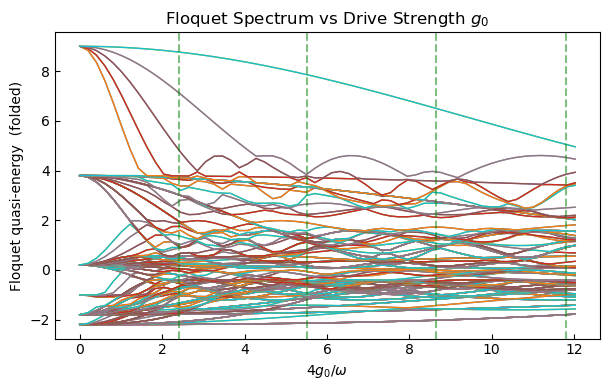

In [6]:
import matplotlib.pyplot as plt

def floquet_spectrum_vs_g0(N, beta, Jvalue, n_ph, hbar, omega, g0_values):
    spectrum = []
    for g0 in g0_values:
        eps = floquet_quasienergies(N, beta, Jvalue, n_ph, hbar, omega, g0)
        spectrum.append(eps)
    return np.array(spectrum)

# Sweep g0 values
g0_values = np.linspace(0, 5*g0_freeze, 60)   # up to 2× first freezing point
spectrum = floquet_spectrum_vs_g0(N, beta, Jvalue, n_ph, hbar, omega, g0_values)

# Convert to scaled variable (this is what appears in freezing theory: 4g0/omega)
xvals = 4 * g0_values / omega

plt.figure(figsize=(6.2,4))
for n in range(spectrum.shape[1]):
    plt.plot(xvals, spectrum[:, n], lw=1)

# mark freezing points (Jn zeros)
for z in jn_zeros(0, 4):
    plt.axvline(x=z, linestyle='--', color='green', alpha=0.5)

plt.xlabel(r"$4 g_0 / \omega$")
plt.ylabel("Floquet quasi-energy  (folded)")
plt.title("Floquet Spectrum vs Drive Strength $g_0$")
plt.tick_params(which='both', direction='in')
plt.tight_layout()
plt.show()
